In [1]:
#from helper import *
#python -m pip install <name of packages/library>
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.models.ldamodel import LdaModel as Lda
from gensim import corpora
#import pyLDAvis
import string
import os
import codecs
import pandas as pd
from openpyxl import Workbook
#import pyLDAvis.gensim
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\VA Lab
[nltk_data]     11\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\VA Lab
[nltk_data]     11\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


C:\conda\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# add log for recording the model fitting data while training

In [2]:
from time import time
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

In [3]:
comments=pd.read_csv("cleaning.csv") # after you create and save a file using SPARK in a different program

In [4]:
comments = comments.tokens_Stop[1:100].tolist() # choose a number of cleaned comments to work on

In [5]:
lemma = WordNetLemmatizer()

In [6]:
# Function to remove stop words from sentences, punctuation & lemmatize words.
def clean(doc):
    exclude = set(string.punctuation)
    translate_table = dict((ord(char), None) for char in string.punctuation)
    no_punct = doc.lower().translate(translate_table)
    stop_free = " ".join([i for i in no_punct.split()])
    normalized = " ".join(lemma.lemmatize(word,'v') for word in stop_free.split())
    
    x = normalized.split()
    y = [s for s in x if len(s) > 2]
    return y

In [7]:
cleanPost = [clean(doc) for doc in comments]

In [8]:
print(len(cleanPost))
#print([len(x) for x in cleanPost])[1:1]
#print(cleanPost)

99


In [9]:
# Find the most frequent words and exclude NEUtral them. My bias!!! May be work more on that?
import itertools
flattened_cleanPost = list(itertools.chain(*cleanPost))

from collections import Counter
word_counts = Counter(flattened_cleanPost)
top_three = word_counts.most_common(200)
print(top_three)

[('government', 44), ('pay', 39), ('work', 35), ('workers', 35), ('job', 32), ('federal', 32), ('canadians', 29), ('provinces', 28), ('tax', 25), ('canada', 23), ('money', 23), ('people', 22), ('transfer', 22), ('canadian', 20), ('health', 20), ('care', 19), ('cost', 18), ('program', 17), ('wag', 17), ('year', 17), ('tfws', 16), ('market', 16), ('economy', 15), ('harper', 15), ('way', 14), ('public', 14), ('worker', 13), ('service', 13), ('feds', 13), ('wage', 12), ('payments', 12), ('pension', 12), ('sick', 12), ('benefit', 11), ('tfw', 11), ('foreign', 11), ('employers', 11), ('time', 11), ('thing', 11), ('cut', 11), ('spend', 11), ('provincial', 11), ('country', 10), ('fund', 10), ('deficit', 10), ('budget', 10), ('employees', 10), ('raise', 9), ('business', 9), ('article', 9), ('problem', 9), ('home', 8), ('increase', 8), ('theyre', 8), ('save', 8), ('financial', 8), ('sector', 8), ('unions', 7), ('temporary', 7), ('hire', 7), ('reason', 7), ('term', 7), ('lower', 7), ('change', 7)

In [10]:
most_fr = pd.DataFrame(top_three, columns=['words','count']).set_index('words')
most_fr.to_excel('most_frequent.xlsx')

In [11]:
import gensim
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

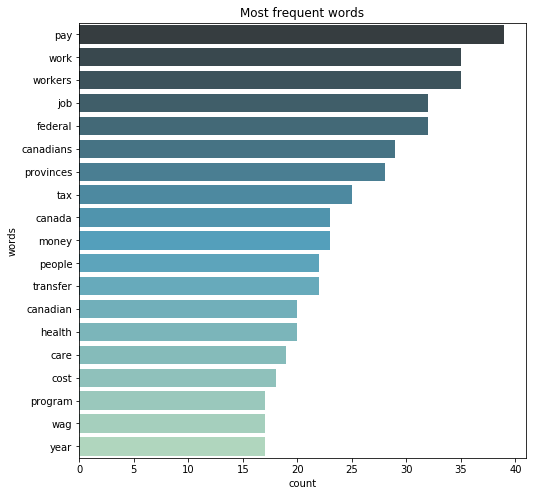

In [12]:
fiz=plt.figure(figsize=(8,8))
#df=pd.DataFrame(lda.show_topic(i), columns=['term','prob']).set_index('term')
#df=df.sort_values('prob')
#plt.subplot(5,2,1)
plt.title('Most frequent words')
sns.barplot(x='count', y=most_fr[1:20].index, data=most_fr[1:20], label='Cities', palette='GnBu_d')
plt.xlabel('count')
fiz.savefig('most_frequent.png')
plt.show()

In [13]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(cleanPost)
dictionary.save('dictionary.dict')
print (dictionary)

Dictionary(1515 unique tokens: ['40hr', 'annual', 'benefit', 'bust', 'election']...)


In [14]:
#After printing the most frequent words of the dictionary, I found that few words which are mostly content neutral words are also present in the dictionary. 
# These words may lead to modeling of “word distribution”(topic) which is neutral and do not capture any theme or content. 
# I made a list of such words and filtered all such words.
stoplist = set('per still that you time back good right disagree obviously self bye see even low less much another will every instead never ask want leave bring give one tell say new try take may come get two three get would seem like want hey might may without also make want put etc actually else far definitely youll\' didnt\' isnt\' theres since able maybe without may suggestedsort never isredditmediadomain userreports far appreciate next think know need look please one null take dont dont\' want\' could able ask well best someone sure lot thank also anyone really something give years use make all ago know many call include part find become '.split())
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)


In [15]:
#build a corpus and save it for a future
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above and save for a future use
doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleanPost]

#corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)
print (len(doc_term_matrix))

99


In [16]:
start = time()
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

#Creating the object for LDA model using gensim library & Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=20, iterations=500)
#ldafile = open('lda_model_sym_wiki.pkl','wb')
#cPickle.dump(ldamodel,ldafile)
#ldafile.close()
print ('used: {:.2f}s'.format(time()-start))

used: 7.45s


In [17]:
#print(ldamodel.print_topics(num_topics=5, num_words=4))
ii = ldamodel.print_topics(num_topics=4, num_words=30)
df = pd.DataFrame(ii, columns=['id_topics', 'words']).set_index('id_topics')
df.head(3)

,words
id_topics,
0,"0.011*""tfws"" + 0.010*""work"" + 0.008*""canada"" +..."
1,"0.010*""workers"" + 0.010*""canadians"" + 0.008*""w..."
2,"0.015*""government"" + 0.014*""pay"" + 0.012*""prov..."


In [18]:
df.to_excel('topics.xlsx')

In [19]:
df = df.to_csv('topics.csv') #save topics to csv file

In [20]:
#Print all the 50 topics
for topic in ldamodel.print_topics(num_topics=50, num_words=10):
    print (topic[0]+1, " ", topic[1],"\n")
    

1   0.011*"tfws" + 0.010*"work" + 0.008*"canada" + 0.008*"pay" + 0.007*"workers" + 0.007*"job" + 0.006*"tfw" + 0.006*"budget" + 0.006*"economy" + 0.006*"way" 

2   0.010*"workers" + 0.010*"canadians" + 0.008*"work" + 0.008*"job" + 0.006*"government" + 0.006*"cyprus" + 0.005*"federal" + 0.004*"save" + 0.004*"employers" + 0.004*"people" 

3   0.015*"government" + 0.014*"pay" + 0.012*"provinces" + 0.010*"tax" + 0.010*"workers" + 0.009*"canadians" + 0.009*"federal" + 0.009*"money" + 0.008*"wag" + 0.008*"care" 

4   0.012*"transfer" + 0.011*"government" + 0.010*"sick" + 0.008*"year" + 0.008*"money" + 0.008*"health" + 0.008*"federal" + 0.007*"job" + 0.007*"payments" + 0.007*"care" 



In [17]:
#save model for future use
ldamodel.save('topic_comments_lda.model')

In [18]:
#load saved model
#from gensim.models import LdaModel
#loading = LdaModel.load('topic_comments_lda.model')

In [19]:
#print(loading.print_topics(num_topics=2, num_words=4))

In [65]:
def visualize(ldamodel,doc_term_matrix, dictionary):
        try:
            pyLDAvis.enable_notebook()
        except:
            print ('not in jupyter notebook')
            

        viz = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
        
        pyLDAvis.save_html(viz, 'TM_viz.html')
        
        return viz

In [66]:
visualize(ldamodel,doc_term_matrix, dictionary)

ModuleNotFoundError: No module named 'pyLDAvis'

In [67]:
ldamodel.save('TM_lda.model')

# Plot words importance

In [59]:
%%time
import gensim
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
lda = gensim.models.LdaModel.load('topic_comments_lda.model')

Wall time: 680 ms


In [68]:
#lda.show_topic(2)


[('article', 0.0088667795),
 ('people', 0.007914071),
 ('read', 0.0069428533),
 ('women', 0.0065802354),
 ('comment', 0.0062736738),
 ('kid', 0.0050650062),
 ('school', 0.0045170886),
 ('children', 0.00434996),
 ('point', 0.0043331934),
 ('write', 0.0042704619)]

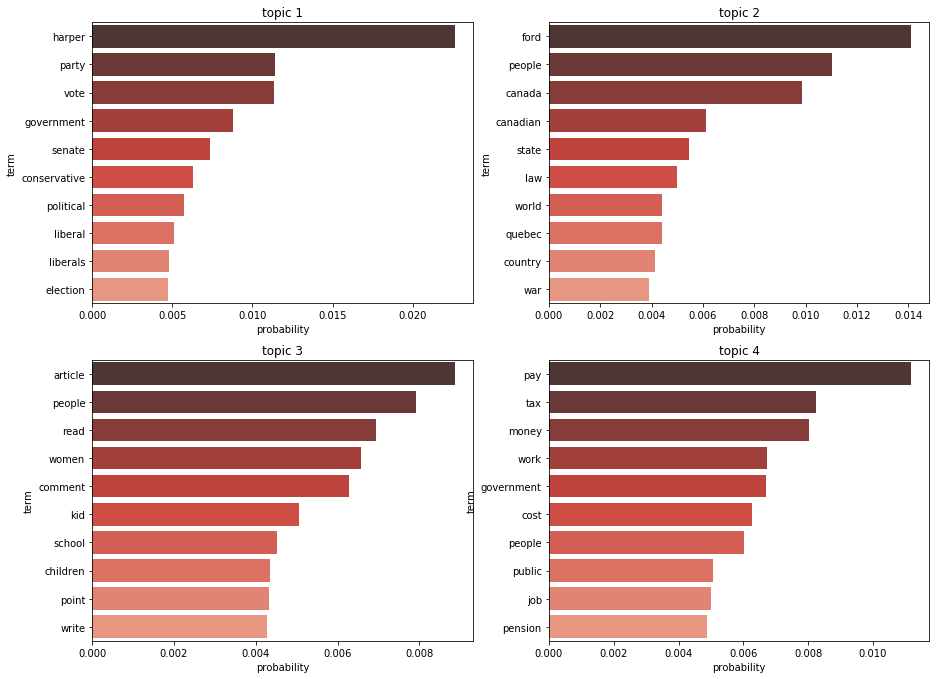

In [60]:
fig=plt.figure(figsize=(15,30))
for i in range(4):
    df=pd.DataFrame(ldamodel.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    df
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
    
fig.savefig('charts.png')
plt.show()

In [62]:
df.index

Index(['pay', 'tax', 'money', 'work', 'government', 'cost', 'people', 'public',
       'job', 'pension'],
      dtype='object', name='term')

In [2]:
#df